In [1]:
# Referring Code From: https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Computer_Vision/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Unet-Brain-MRI-Segmentation-Tensorflow-Keras.ipynb
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2 
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [2]:
# Setting size parameters of images
im_width = 256
im_height = 256

# Loading the image and mask paths

In [4]:
image_filenames_train= glob('C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img/*')
# creating a list of all files containing the word 'mask'

mask_files = glob('C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask/*')

print(image_filenames_train[:10])
len(image_filenames_train)

['C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice000_x.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice000_y.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice001_x.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice001_y.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice002_x.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice002_y.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice003_x.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice003_y.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice004_x.png', 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice004_y.png']


4086

In [5]:
mask_files

['C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice000_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice000_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice001_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice001_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice002_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice002_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice003_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice003_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice004_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice004_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice005_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice005_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test//mask\\brain0-slice006_x.png',

In [6]:
len(mask_files)

4086

In [7]:
image_filenames_train

['C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice000_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice000_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice001_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice001_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice002_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice002_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice003_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice003_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice004_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice004_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice005_x.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice005_y.png',
 'C:/Users/Pc/OneDrive/Bureau/ATLAS/data/test/img\\brain0-slice006_x.png',
 'C:/Users/Pc/OneDrive/Bu

# Plotting few images and masks

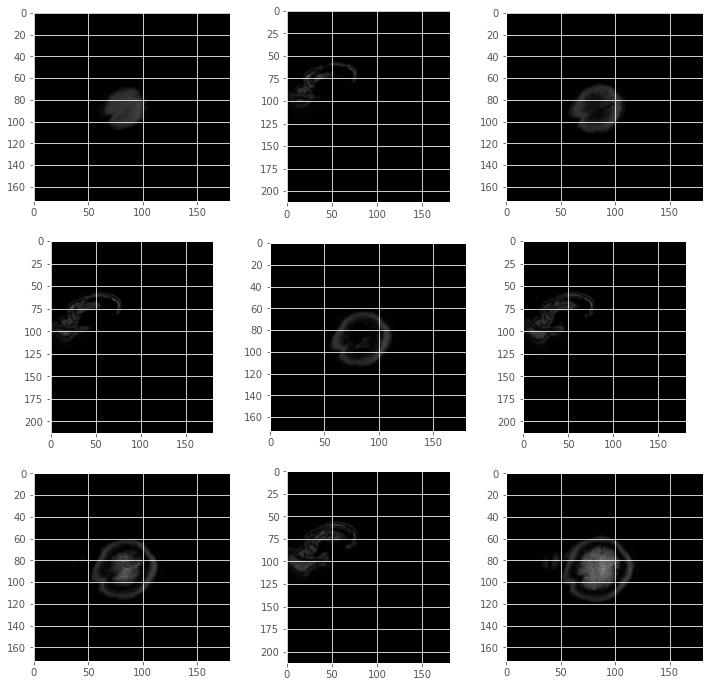

In [16]:
plot_from_img_path(3, 3, image_filenames_train, mask_files )

# Create data frame and split data on train set, validation set and test set

In [17]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2941, 2)
(409, 2)
(736, 2)


# Data genertator, data augmentation and adjust data

In [18]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [19]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any lesion '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1 #there is a lesion
    mask[mask <= 0.5] = 0 #nothing
    return(img, mask)

In [23]:
EPOCHS = 10
BATCH_SIZE = 1
learning_rate = 1e-4
smooth=100

In [24]:
model = unet()
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x0000028EAA0A9A30>>

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [26]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2941 validated image filenames.
Found 2941 validated image filenames.
Epoch 1/10
2941/2941 [==============================] - ETA: 0s - loss: -0.3978 - binary_accuracy: 0.9544 - iou: 0.3936 - dice_coefficients: 0.3978Found 736 validated image filenames.
Found 736 validated image filenames.
2941/2941 [==============================] - 325s 107ms/step - loss: -0.3978 - binary_accuracy: 0.9544 - iou: 0.3936 - dice_coefficients: 0.3978 - val_loss: -0.7714 - val_binary_accuracy: 0.9951 - val_iou: 0.7714 - val_dice_coefficients: 0.7714

Epoch 00001: val_loss improved from inf to -0.77144, saving model to unet.hdf5
Epoch 2/10
2941/2941 [==============================] - 355s 121ms/step - loss: -0.7842 - binary_accuracy: 0.9946 - iou: 0.7842 - dice_coefficients: 0.7842 - val_loss: -0.7818 - val_binary_accuracy: 0.9950 - val_iou: 0.7818 - val_dice_coefficients: 0.7818

Epoch 00002: val_loss improved from -0.77144 to -0.78183, saving model to unet.hdf5
Epoch 3/10
2941/2941 [===============

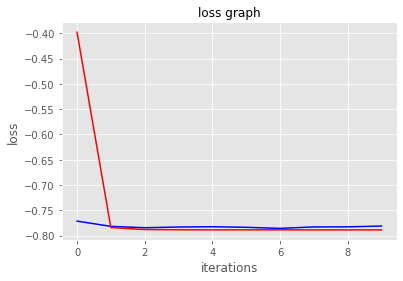

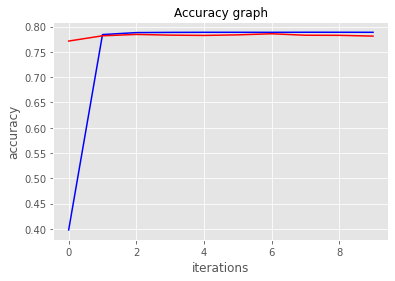

In [36]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [38]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  } )


In [39]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 409 validated image filenames.
Found 409 validated image filenames.
409/409 [==============================] - 13s 30ms/step - loss: -0.7883 - binary_accuracy: 0.9948 - iou: 0.7883 - dice_coefficients: 0.78831s - loss: -0.7812
Test Loss  -0.7882565855979919
Test IoU  0.9947856068611145
Test Dice Coefficient  0.7882565855979919


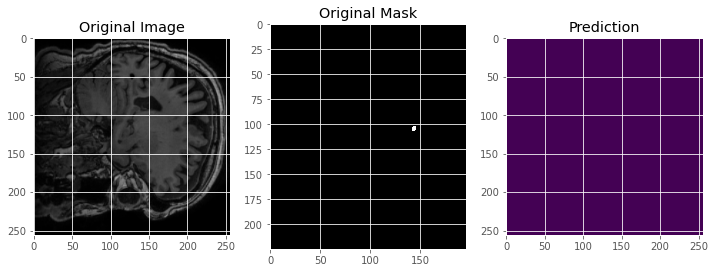

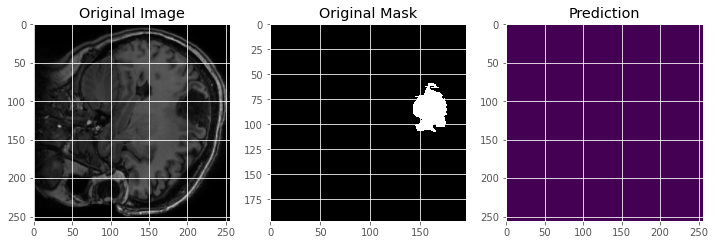

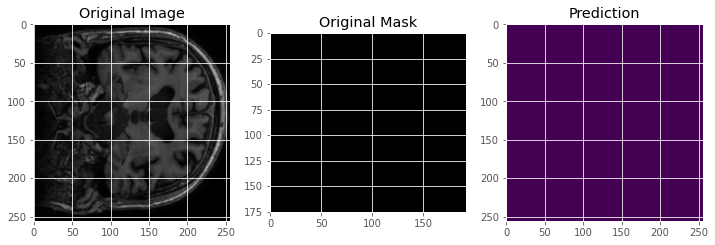

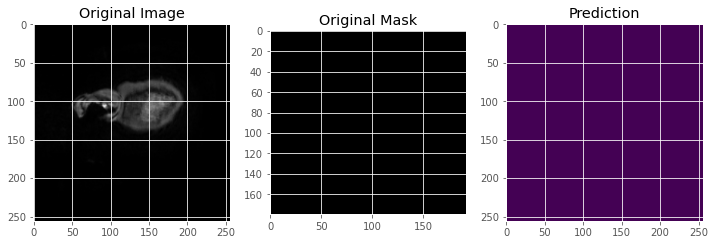

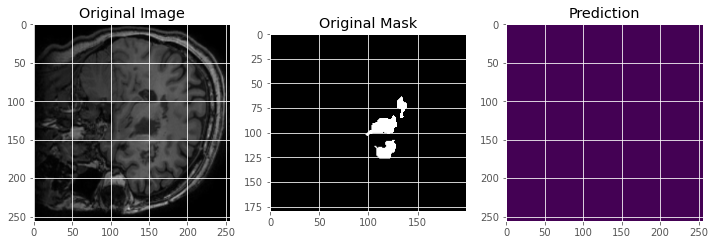

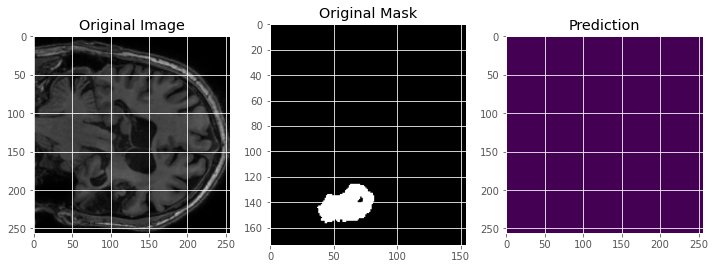

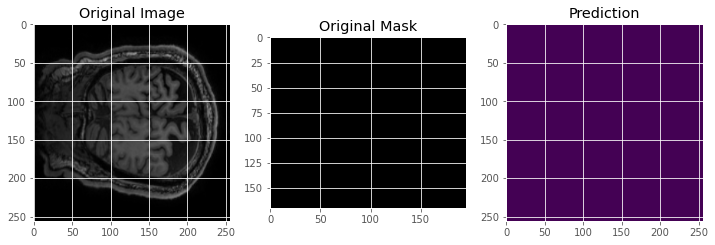

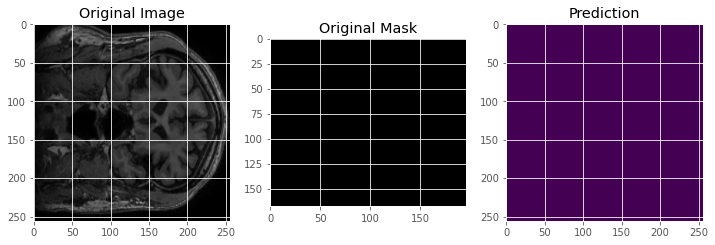

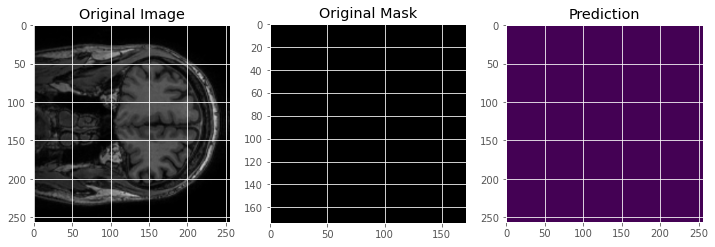

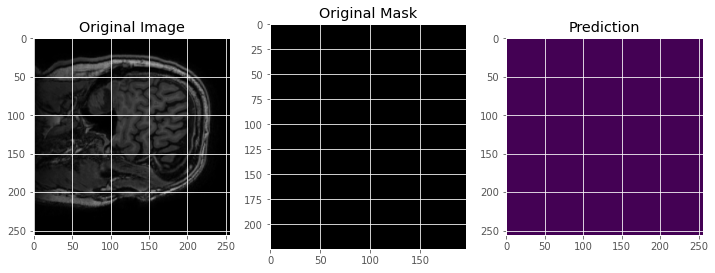

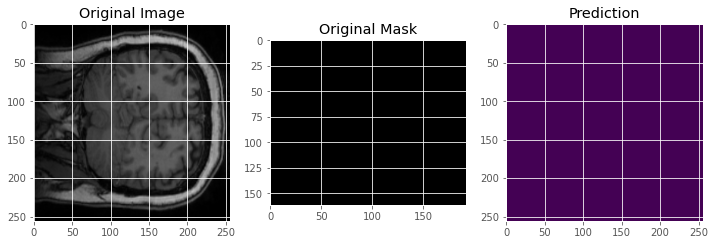

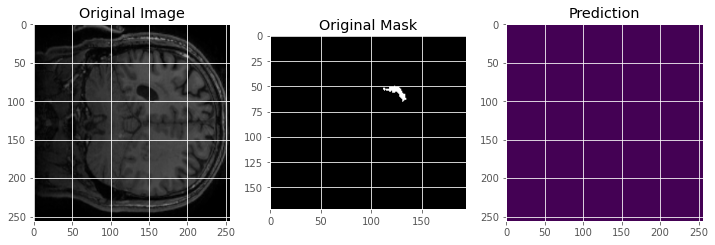

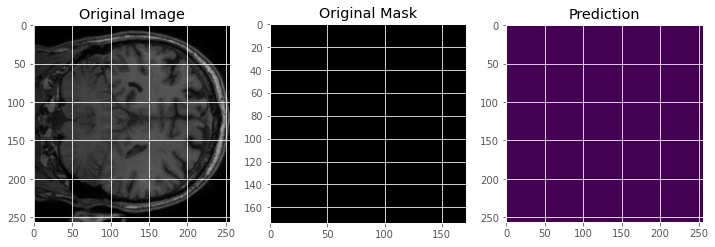

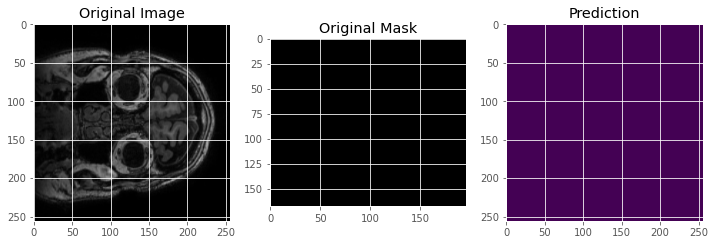

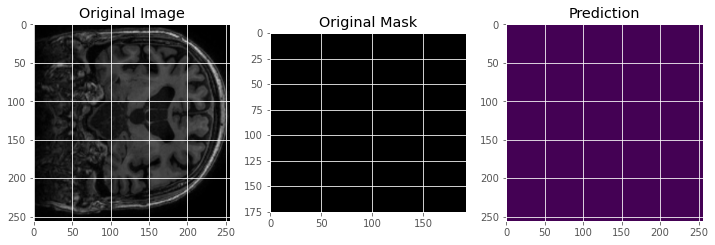

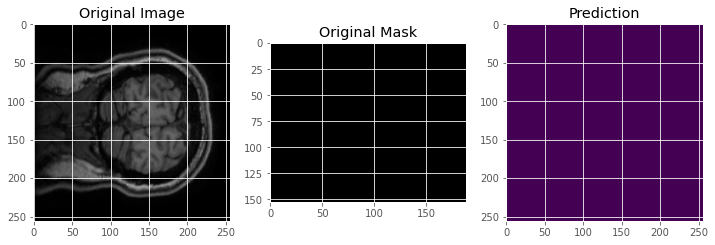

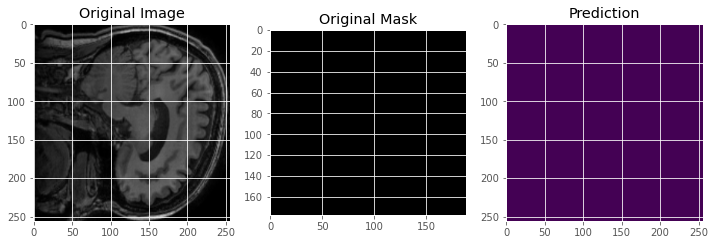

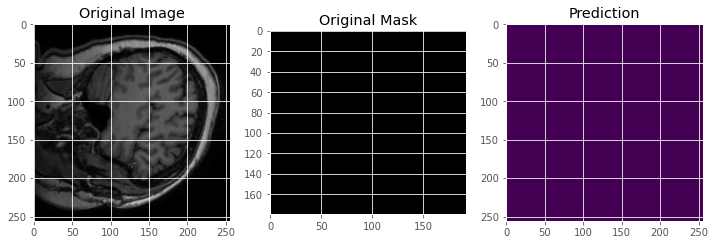

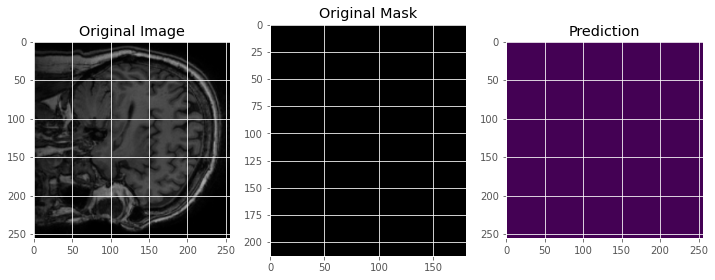

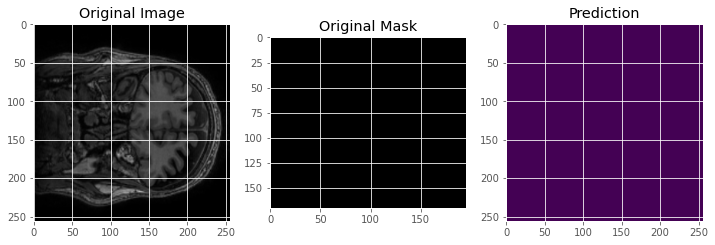

In [42]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()